In [1]:
## Transformers
from transformers import TFDistilBertModel, DistilBertConfig

## Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate

## Utilities
from utils.OneCycleScheduler import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

In [2]:
## Check GPU availability
tf.test.is_built_with_cuda(), tf.config.list_physical_devices('GPU')

(True, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

### Load Data

In [3]:
f = open('../data/preprocessed.pkl','rb')
train, valid = pickle.load(f)

## Sample subset of train for testing
# train = train.sample(frac = 0.2)
# valid = valid.sample(frac = 0.2)

labels = train.columns[2:]
ys_train = train[labels]
ys_valid = valid[labels]

## COMBINE TOXIC CATEGORIES
y_train = ys_train.sum(axis=1)
y_valid = ys_valid.sum(axis=1)
y_train.loc[y_train>1] = 1
y_valid.loc[y_valid>1] = 1

### Build tokenizer

In [4]:
## Load pretrained Distil Bert Tokenizer
from transformers import DistilBertTokenizer
distil_bert = 'distilbert-base-uncased' # pre-trained model
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

In [5]:
## Tokenizer function
def tokenize(sentences, tokenizer, max_length = 128):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, 
                                    add_special_tokens=True, 
                                    max_length = max_length, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True, 
                                    truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [6]:
## Tokenize all
train_ids, train_masks, train_segs = tokenize(train['comment_text'], tokenizer)
valid_ids, valid_masks, valid_segs = tokenize(valid['comment_text'], tokenizer)

In [7]:
train_ids.shape, train_masks.shape, train_segs.shape

((106912, 128), (106912, 128), (106912, 128))

### Load colab-trained modeL

In [8]:
def build_model():
    # Configure transformer model
    config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

    # Inputs
    input_ids = Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_ids = Input(shape=(128,), name='masked_token', dtype='int32')

    # Transformer layer
    X = transformer_model(input_ids, attention_mask=input_masks_ids)[0]

    ## Keras Convolutional FIlters (4 blocks of prallel convolutional filters [size 2, 4, and 6])
    X_2 = Conv1D(filters=50,kernel_size=2,padding='same',activation='relu', name = 'Conv2_b1')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,padding='same',activation='relu', name = 'Conv4_b1')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,padding='same',activation='relu', name = 'Conv6_b1')(X)
    X = Concatenate(axis=-1, name = 'cat_b1')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b1')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b2')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b2')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b2')(X)
    X = Concatenate(axis=-1, name = 'cat_b2')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b2')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b3')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b3')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b3')(X)
    X = Concatenate(axis=-1, name ='cat_b3')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b3')(X)
    X_2 = Conv1D(filters=50,kernel_size=2,strides = 2, padding='same',activation='relu', name = 'Conv2_b4')(X)
    X_4 = Conv1D(filters=50,kernel_size=4,strides = 2, padding='same',activation='relu', name = 'Conv4_b4')(X)
    X_6 = Conv1D(filters=50,kernel_size=6,strides = 2, padding='same',activation='relu', name = 'Conv6_b4')(X)
    X = Concatenate(axis=-1, name= 'cat_b4')([X_2, X_4, X_6]) 
    X = BatchNormalization(name = 'batchnorm_b4')(X)
    X_Max = GlobalMaxPooling1D()(X)
    X_Avg = GlobalAveragePooling1D()(X)
    X = Concatenate(axis=-1)([X_Max,X_Avg])
    X = Dense(100, activation = 'relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

    # Freeze transformer layers
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [9]:
model = build_model()
model.load_weights('F:\Google Drive\distilbert_colab')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
## Get predictions
## Not enough video memory (8GB) to run Convolutional layers on transformer embeddings.
## Enough memory if sequence is reduced into concatenated global average pool and max pool. 
preds = model.predict([valid_ids, valid_masks], batch_size=1)
preds_df = pd.DataFrame(data=preds, columns=['distilbert'])
preds_df.to_csv('../artifacts/simple/preds/distilbert.csv')
preds_t = preds
preds_t[preds_t<=0.5] = 0
preds_t[preds_t>0.5] = 1

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_1/Conv2_b1/conv1d (defined at <ipython-input-10-0013af46070b>:2) ]] [Op:__inference_predict_function_6686]

Function call stack:
predict_function


### Simpler Model Builder for local training

In [8]:
def build_model():
    # Configure transformer model
    config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
    config.output_hidden_states = False
    transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

    # Inputs
    input_ids = Input(shape=(128,), name='input_token', dtype='int32')
    input_masks_ids = Input(shape=(128,), name='masked_token', dtype='int32')

    # Transformer layer
    X = transformer_model(input_ids, attention_mask=input_masks_ids)[0]

    ## Keras layers
    X_Max = GlobalMaxPooling1D()(X)
    X_Avg = GlobalAveragePooling1D()(X)
    X = Concatenate(axis=-1)([X_Max,X_Avg])
    X = Dense(300, activation = 'relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

    # Freeze transformer layers
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [9]:
model = build_model()
print(model.summary())

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Model: "functional_1"
__________________________________________________

### Find Learning rate

In [13]:
bs = 5 # batch size

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

lr_finder = LRFinder(max_steps=100) # setup lrfinder. See document for max_lr and min_lr

_ = model.fit(x = [train_ids, train_masks],
              y = y_train,
              batch_size=bs,
              steps_per_epoch=100,
              callbacks=[lr_finder])

100/100 [==============================] - 3s 26ms/step - loss: 199.3516 - acc: 0.5980


(0.0, 3.0)

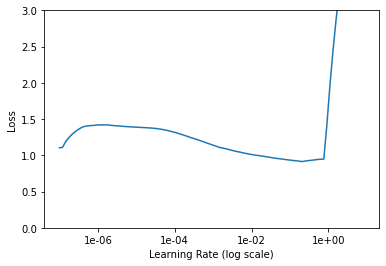

In [14]:
fig, ax = lr_finder.plot()
ax.set_ylim([0,3])

(-0.02, 0.0)

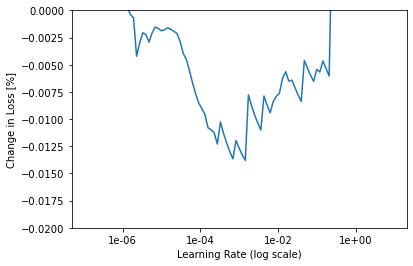

In [17]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.02,0])
# 1e-5 seems good

In [25]:
## Build model
model = build_model()

## Params
epochs = 1000
steps_per_epoch = np.floor(len(train_ids)/bs)

## Define Learning scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta = 0.0001, patience = 20)

## Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='binary_crossentropy',
              metrics='acc')

## Fit model
history = model.fit(x = [train_ids, train_masks],
                    y = y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_split = 0.05,
                    callbacks=[lr_scheduler, es]) # add scheduler as callback

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Epoch 1/100
4276/4276 [==============================] - 114s 27ms/step 

In [26]:
## Get predictions
preds = model.predict([valid_ids, valid_masks], batch_size=5)
preds_df = pd.DataFrame(data=preds, columns=['distilbert'])
preds_df.to_csv('../artifacts/simple/preds/distilbert.csv')
preds_t = preds
preds_t[preds_t<=0.5] = 0
preds_t[preds_t>0.5] = 1

In [27]:
results = pd.DataFrame(columns=['Label','Accuracy', 'Recall', 'Precision', 'F1', 'Vectorizer', 'model'])

## Print results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

i_preds = preds_t
i_true = y_valid

# Evaluate predictions
acc, prec, recall, f1 = (accuracy_score(i_true, i_preds), 
                        precision_score(i_true, i_preds), 
                        recall_score(i_true, i_preds), 
                        f1_score(i_true, i_preds))

# Save results to dataframe
results = results.append({'Label': 'Toxic_Combined',
                        'Accuracy':acc,
                        'Recall':recall,
                        'Precision':prec,
                        'F1':f1,
                        'Vectorizer':'N/A',
                        'model': 'distilbert'}, 
                        ignore_index = True)

# print results
print('Results for {0} comments: Accuracy - {1:.2f}; Precision - {2:.2f}; Recall - {3:.2f}; F1 - {4:.2f}'.format(
                                'Toxic_Combined', 
                                acc, 
                                prec, 
                                recall,
                                f1))

Results for Toxic_Combined comments: Accuracy - 0.95; Precision - 0.87; Recall - 0.64; F1 - 0.74


In [32]:
model.save_weights('../artifacts/simple/distilbert')